In [30]:
%matplotlib inline

In [31]:
import os
import sys

project_dir = os.path.split(os.getcwd())[0]

if project_dir not in sys.path:
   sys.path.append(project_dir)

from lyricanalysis import corpus

# Load up all of the songs for given artist

In [32]:
artist = 'Twenty One Pilots'
songs = corpus.songs_for_artist(artist)

# Clean the lyrics

In [33]:
import re

tagged = re.compile('\[.*\]')
produced = re.compile('[p|P]roduced.*')

def clean_lyrics(lyrics):
    new_lyrics = tagged.sub('', lyrics)
    new_lyrics = produced.sub('', new_lyrics)
    
    return new_lyrics

for song in songs:
    song['lyrics'] = clean_lyrics(song['lyrics'])

# Word tokenize, remove stop words and stem

In [34]:
import string
import unicodedata
import sys

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import PorterStemmer

import pandas as pd
import seaborn as sns

punc_tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def stem_words(words):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in words]

def remove_punctuation(text):
    return text.translate(punc_tbl)

def remove_stop_words(words):
    """Remove stop words from a list of words."""
    wl = []    
    stop_words = corpus.stop_words()
    for word in words:
        word = word.lower()
        if word not in stop_words:
            wl.append(word)
    
    return wl

normalized_word_frequencies = {}

for song in songs:
    song['word_tokens'] = stem_words(remove_stop_words(word_tokenize(remove_punctuation(song['lyrics']))))
    song['word_count'] = len(song['word_tokens'])
    dist = FreqDist(song['word_tokens'])

    for w in dist:
        if not w in normalized_word_frequencies:
            normalized_word_frequencies[w] = 0

        normalized_word_frequencies[w] = normalized_word_frequencies[w] + dist.freq(w)
        
for w, v in normalized_word_frequencies.items():
    normalized_word_frequencies[w] = v / len(songs)

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


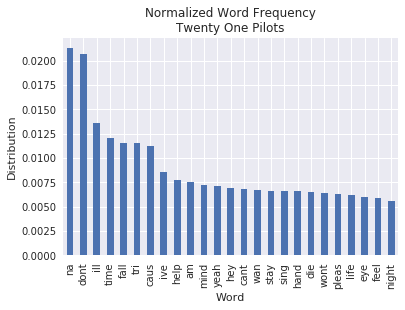

In [35]:
df = pd.DataFrame.from_dict(normalized_word_frequencies, orient='index')
word_freq = df.nlargest(25, 0).plot(kind='bar', title='Normalized Word Frequency\n%s' % (artist), legend=False)
word_freq.set_xlabel("Word")
word_freq.set_ylabel("Distribution")

# Stemmed and normalized swear word frequency

In [36]:
swear_words = set(stem_words(corpus.swear_words()))

normalized_word_frequencies = {}

for song in songs:
    song['word_tokens'] = stem_words(remove_stop_words(word_tokenize(remove_punctuation(song['lyrics']))))
    dist = FreqDist(song['word_tokens'])

    for sw in swear_words:
        if not sw in normalized_word_frequencies:
            normalized_word_frequencies[sw] = 0

        normalized_word_frequencies[sw] = normalized_word_frequencies[sw] + dist.freq(sw)
        
for w, v in normalized_word_frequencies.items():
    normalized_word_frequencies[w] = v / len(songs)

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


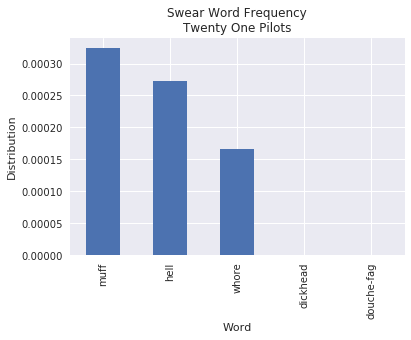

In [41]:
df = pd.DataFrame.from_dict(normalized_word_frequencies, orient='index')
word_freq = df.nlargest(5, 0)[0:5].plot(kind='bar', title='Swear Word Frequency\n%s' % (artist), legend=False)
word_freq.set_xlabel("Word")
word_freq.set_ylabel("Distribution")

# Sentiment analysis with Vader

In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize


def split_sentences(text):
    sentences = []
    for sentence in text.split('\n'):
        sentence = sentence.strip()
        
        if sentence:
            sentences.append(sentence)

    return sentences


def sentiment_for_song(text):
    sid = SentimentIntensityAnalyzer()

    # can't use sent_tokenize with lyrics... just split on newline
    sentences = split_sentences(text)
    total_ss = {
        'negative': 0,
        'positive': 0,
        'neutral': 0,
        'compound': 0
    }

    for sentence in sentences:
        ss = sid.polarity_scores(sentence)
        total_ss['negative'] = total_ss['negative'] + ss['neg']
        total_ss['positive'] = total_ss['positive'] + ss['pos']
        total_ss['neutral'] = total_ss['neutral'] + ss['neu']
        total_ss['compound'] = total_ss['compound'] + ss['compound']
        
    for key in total_ss:
        if len(sentences) > 0:
            total_ss[key] = total_ss[key] / len(sentences)
        
    return total_ss

all_sentiments = {}
for song in songs:
    sentiments = sentiment_for_song(song['lyrics'])

    # add sentiment to song data
    song['positive_sentiment'] = sentiments['positive']
    song['negative_sentiment'] = sentiments['negative']
    song['neutral_sentiment'] = sentiments['neutral']
    
    for key in sentiments:
        if key not in all_sentiments:
            all_sentiments[key] = 0
            
        all_sentiments[key] = all_sentiments[key] + sentiments[key]

# normalize for number of songs

for key in all_sentiments:
    all_sentiments[key] = all_sentiments[key] / len(songs)

print(all_sentiments)

/software/miniconda3/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


{'negative': 0.09068995201185456, 'positive': 0.09447191363894629, 'neutral': 0.8148361725926274, 'compound': 0.007591766137715901}


/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


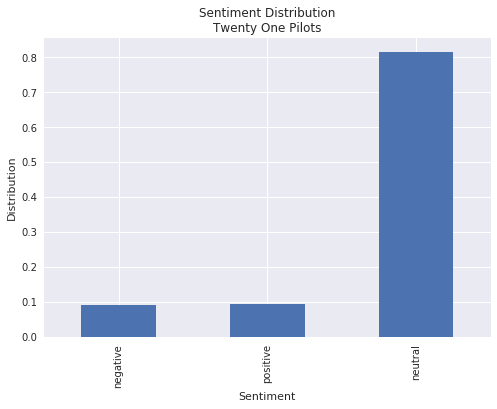

In [10]:
all_sentiments.pop('compound', 0)
df = pd.DataFrame.from_dict(all_sentiments, orient='index')
sent_plot = df.plot(kind='bar', title='Sentiment Distribution\n%s' % (artist), legend=False)
sent_plot.set_xlabel("Sentiment")
sent_plot.set_ylabel("Distribution")
sent_df = df

# How repetitive?

Check how repetitive a song is by looking at the number of occurences each phrase or sentence has. A lot of songs are repetitive due to the nature of a chorus etc.. however some might be super repetitve.

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


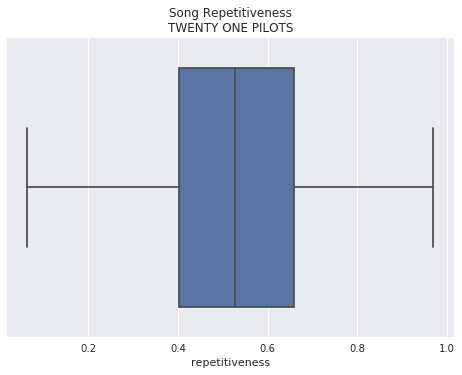

In [11]:
def song_repetiveness(lyrics, rate=2):
    # split song on sentence and find unique sentences
    sentences = split_sentences(lyrics)
    unique_sentences = set(sentences)
    
    total_sentences = len(sentences)
    total_unique_sentences = len(unique_sentences)
    
    # collect frequency of unique sentences and calculate reptetiveness
    repetitive_rate = 0
    frequency = 0
    for usentence in unique_sentences:
        for sentence in sentences:
            if usentence == sentence:
                frequency = frequency + 1

        # only calc. reptetiveness rate if frequency rate cutoff is met
        if frequency >= rate:
            repetitive_rate = repetitive_rate + (frequency / total_sentences)
            
        frequency = 0
        
    return repetitive_rate

for song in songs:
    song['repetitiveness'] = song_repetiveness(song['lyrics'], rate=2)
    
songs_df = pd.DataFrame.from_dict(songs)
# plot = songs_df.sort_values('repetitiveness').plot(y='repetitiveness', kind='box', title='Song Repetitiveness\n%s' % (songs[0]['artist']), stacked=True)
sns.boxplot(songs_df.repetitiveness)

sns.plt.title('Song Repetitiveness\n%s' % (songs[0]['artist'])) 

In [12]:
songs_df.sort_values('repetitiveness').head()

,album,artist,lyrics,lyrics_file,lyrics_file_path,lyrics_url,negative_sentiment,neutral_sentiment,positive_sentiment,repetitiveness,title,word_count,word_tokens
26,Regional At Best,TWENTY ONE PILOTS,"\n\nWhere'd you go, huh?\nThey all think I kno...",twenty-one-pilots-be-concerned.txt,/media/sf_D_DRIVE/jupyter/tyler/single_artist_...,http://www.azlyrics.com/lyrics/twentyonepilots...,0.101362,0.828511,0.070128,0.063830,Be Concerned,107,"[where, huh, hard, motiv, devot, singl, inch, ..."
21,Regional At Best,TWENTY ONE PILOTS,"\n\nNobody thinks what I think,\nNobody dreams...",twenty-one-pilots-kitchen-sink.txt,/media/sf_D_DRIVE/jupyter/tyler/single_artist_...,http://www.azlyrics.com/lyrics/twentyonepilots...,0.138405,0.745643,0.115952,0.119048,Kitchen Sink,114,"[dream, blink, brink, blasphemi, own, shrink, ..."
5,Twenty One Pilots,TWENTY ONE PILOTS,\n\nThere's miles of land in front of us\nAnd ...,twenty-one-pilots-march-to-the-sea.txt,/media/sf_D_DRIVE/jupyter/tyler/single_artist_...,http://www.azlyrics.com/lyrics/twentyonepilots...,0.045511,0.943267,0.011222,0.155556,March To The Sea,103,"[there, mile, land, front, die, step, die, bre..."
29,Vessel,TWENTY ONE PILOTS,"\n\nI'm taking over my body,\nBack in control,...",twenty-one-pilots-holding-on-to-you.txt,/media/sf_D_DRIVE/jupyter/tyler/single_artist_...,http://www.azlyrics.com/lyrics/twentyonepilots...,0.069240,0.899600,0.031160,0.160000,Holding On To You,115,"[take, bodi, control, shotti, bet, lot, lost, ..."
15,Regional At Best,TWENTY ONE PILOTS,"\n\nI'm taking over my body,\nBack in control,...",twenty-one-pilots-holding-on-to-you.txt,/media/sf_D_DRIVE/jupyter/tyler/single_artist_...,http://www.azlyrics.com/lyrics/twentyonepilots...,0.069240,0.899600,0.031160,0.160000,Holding On To You,115,"[take, bodi, control, shotti, bet, lot, lost, ..."


# Correlations...

In [13]:
songs_df.describe()

,negative_sentiment,neutral_sentiment,positive_sentiment,repetitiveness,word_count
count,63.000000,63.000000,63.000000,63.000000,63.000000
mean,0.090690,0.814836,0.094472,0.524446,111.031746
std,0.050765,0.089371,0.068623,0.212027,41.744603
min,0.000000,0.497456,0.000000,0.063830,19.000000
25%,0.051502,0.772568,0.059800,0.402899,78.000000
50%,0.083375,0.829156,0.078426,0.526316,112.000000
75%,0.119803,0.870338,0.116164,0.659787,139.000000
max,0.216706,0.982000,0.374333,0.969697,191.000000


# TFIDF SKLEARN

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0, stop_words = corpus.stop_words())

song_corpus = [song['lyrics'] for song in songs]

tfidf_matrix = tf.fit_transform(song_corpus)
feature_names = tf.get_feature_names()
dense = tfidf_matrix.todense()
song = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(song)), song) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:20]:
   print('{0: <20} {1}'.format(phrase, score))

reign                0.6059994104202604
destroy reign        0.40399960694684023
reign destroy        0.40399960694684023
destroy              0.36731858776618065
ahead                0.13466653564894673
ahead look           0.06733326782447337
ahead reign          0.06733326782447337
am calling           0.06733326782447337
am simply            0.06733326782447337
calling lightning    0.06733326782447337
dark hiding          0.06733326782447337
day ahead            0.06733326782447337
disrespect am        0.06733326782447337
fire day             0.06733326782447337
hiding ahead         0.06733326782447337
liar                 0.06733326782447337
liar set             0.06733326782447337
lightning            0.06733326782447337
lightning dark       0.06733326782447337
look strike          0.06733326782447337


# Topic modelling...

In [15]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print()
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_topics = 5

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf_matrix)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=20, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf_matrix)

no_top_words = 5
display_topics(nmf, feature_names, no_top_words)
display_topics(lda, feature_names, no_top_words)

Topic 0:

tell ll tell plans ll tell plans
Topic 1:

na na na hello hello hello silent trees
Topic 2:

hey hey hey trying trying trying trying sleep
Topic 3:

sit sit silence silence car radio sit
Topic 4:

play pretend pretend wish stressed re stressed
Topic 0:

na na na ll tell reign
Topic 1:

da hey hey hey trying trying trying
Topic 2:

bah re broken bah bah broken doo
Topic 3:

fall don heart won watch
Topic 4:

save re alive stay alive eh eh


# Find most repetitive, positive and negative song

In [16]:
songs_df[['album', 'title', 'repetitiveness']].nlargest(1, 'repetitiveness')

,album,title,repetitiveness
25,Regional At Best,Trees,0.969697
38,Vessel,Trees,0.969697


In [17]:
songs_df[['album', 'title', 'positive_sentiment']].nlargest(1, 'positive_sentiment')

,album,title,positive_sentiment
56,,Can't Help Falling In Love,0.374333


In [18]:
songs_df[['album', 'title', 'negative_sentiment']].nlargest(1, 'negative_sentiment')

,album,title,negative_sentiment
47,Blurryface,Doubt,0.216706


# Find longest and shortest song

In [19]:
songs_df[['album', 'title', 'word_count']].nlargest(1, 'word_count')

,album,title,word_count
16,Regional At Best,Ode To Sleep,191
28,Vessel,Ode To Sleep,191


In [20]:
songs_df[['album', 'title', 'word_count']].nsmallest(1, 'word_count')

,album,title,word_count
60,,Mexico City Song,19


/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


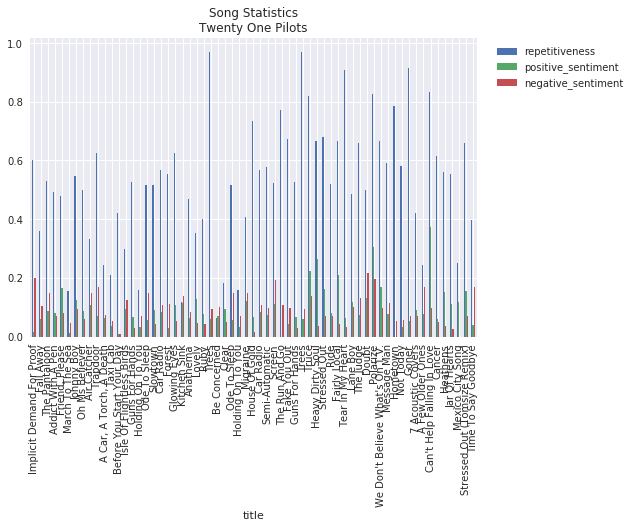

In [21]:
plot = songs_df[['title', 'repetitiveness', 'positive_sentiment', 'negative_sentiment']].plot(kind='bar', x='title', title='Song Statistics\n%s' % (artist))
plot.legend(bbox_to_anchor=(1.35, 1), loc='upper right', ncol=1)

# Find most repetitive, positive and negative album

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


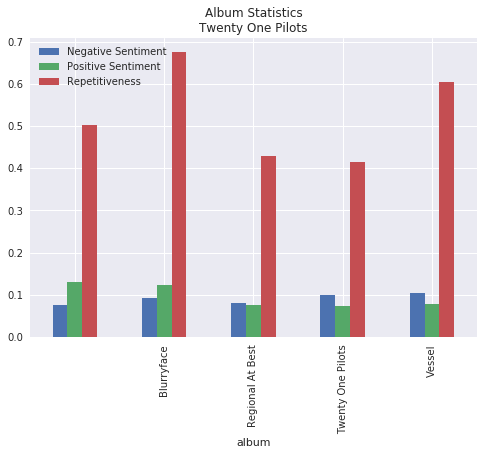

In [22]:
albums_groups = songs_df.groupby('album')['repetitiveness', 'negative_sentiment', 'positive_sentiment', 'word_count'].agg(['count', 'sum'])
albums_groups['repetitiveness_normalized'] = albums_groups['repetitiveness']['sum'] / albums_groups['repetitiveness']['count']
albums_groups['negative_sentiment_normalized'] = albums_groups['negative_sentiment']['sum'] / albums_groups['negative_sentiment']['count']
albums_groups['positive_sentiment_normalized'] = albums_groups['positive_sentiment']['sum'] / albums_groups['positive_sentiment']['count']
albums_groups['words_per_song'] = albums_groups['word_count']['sum'] / albums_groups['word_count']['count']
albums_groups.drop('repetitiveness', axis=1, inplace=True)
albums_groups.drop('positive_sentiment', axis=1, inplace=True)
albums_groups.drop('negative_sentiment', axis=1, inplace=True)
albums_groups.drop('word_count', axis=1, inplace=True)
album_stats = albums_groups.reset_index().stack()
album_stats = album_stats.rename(columns = {'repetitiveness_normalized':'Repetitiveness', 'negative_sentiment_normalized': 'Negative Sentiment', 'positive_sentiment_normalized': 'Positive Sentiment', 'words_per_song': 'Avg. Words Per Song'})
album_stats[['album', 'Negative Sentiment', 'Positive Sentiment', 'Repetitiveness']].plot(kind='bar', x='album', title='Album Statistics\n%s' % (artist))

# Find average words per song for each album

/software/miniconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


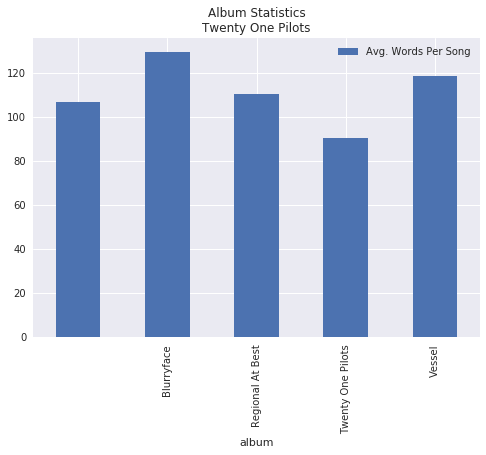

In [23]:
album_stats[['album', 'Avg. Words Per Song']].plot(kind='bar', x='album', title='Album Statistics\n%s' % (artist))

# Most repetitive album

In [24]:
album_stats.nlargest(1, 'Repetitiveness')

,,album,Negative Sentiment,Positive Sentiment,Repetitiveness,Avg. Words Per Song
1,,Blurryface,0.091901,0.124535,0.674829,129.214286


# Most positive  album

In [25]:
album_stats.nlargest(1, 'Positive Sentiment')

,,album,Negative Sentiment,Positive Sentiment,Repetitiveness,Avg. Words Per Song
0,,,0.076503,0.130161,0.503605,106.444444


# Most negative  album

In [26]:
album_stats.nlargest(1, 'Negative Sentiment')

,,album,Negative Sentiment,Positive Sentiment,Repetitiveness,Avg. Words Per Song
4,,Vessel,0.103477,0.078522,0.603729,118.333333
